
## Import required libraries for this project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Explore sample images

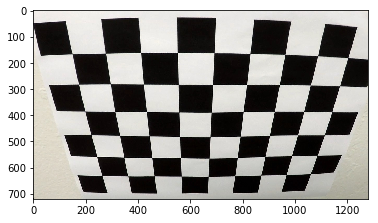

In [2]:
img = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)

## Calibrate camera

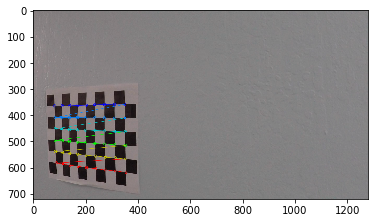

In [3]:
nx, ny = 9, 6

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        
        cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

## Calibration

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

## Undistortion

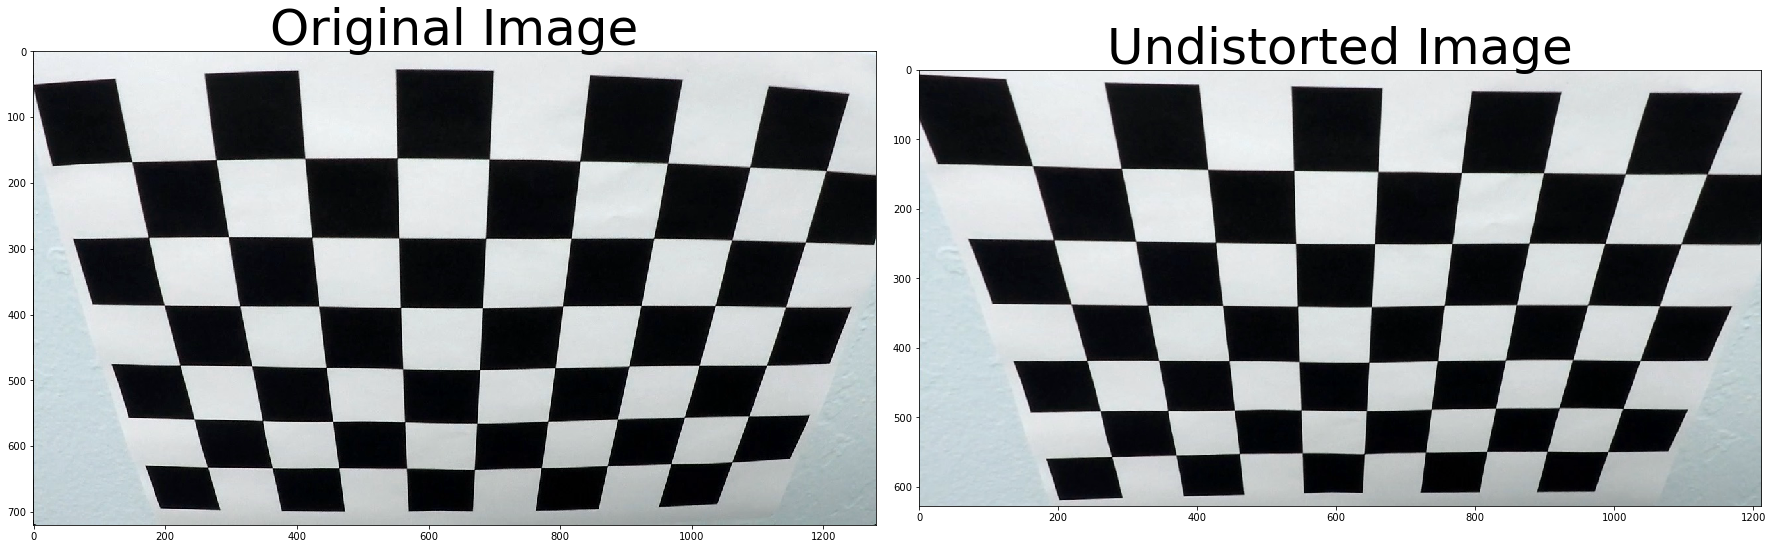

In [5]:
img = cv2.imread('camera_cal/calibration2.jpg')
h, w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

# undistort
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
undistorted = undistorted[y:y+h, x:x+w]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Sobel

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return grad_binary

## Magnitude of the gradient

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

## Direction of the gradient

In [8]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

In [9]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

In [10]:
image = mpimg.imread('test_images/straight_lines1.jpg')
h, w = img.shape[:2]

## Color transforms

In [52]:
def get_threshold(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined = ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = image[:,:,0]
    G = image[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    # color channel thresholds
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]

    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])

    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,h-1], [w/2, int(0.5*h)], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    return thresholded

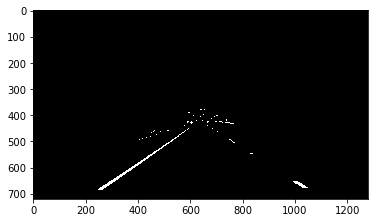

In [53]:
plt.imshow(get_threshold(image), cmap='gray')

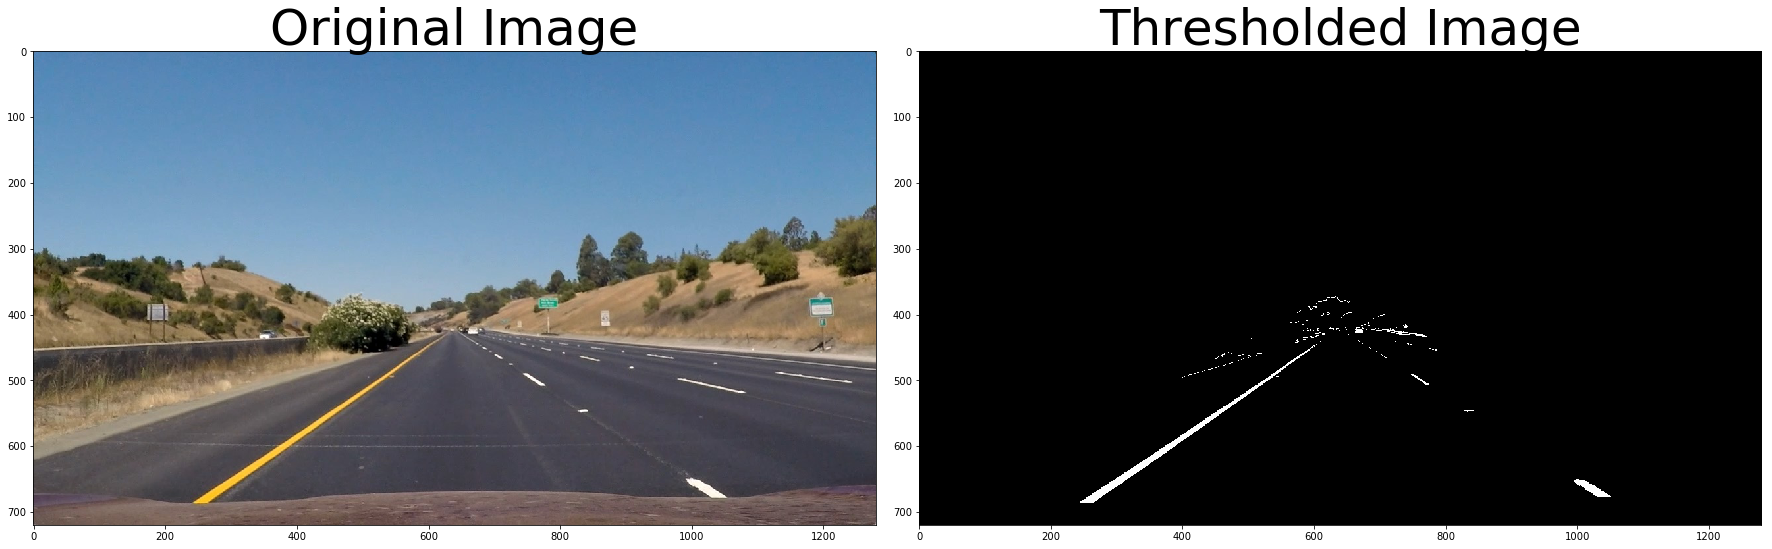

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

In [56]:
# source points
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

# destination points
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])

# get perspective transform
M = cv2.getPerspectiveTransform(source, dst)

# get inverse perspective transform
M_inv = cv2.getPerspectiveTransform(dst, source)

image_shape = image.shape
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)

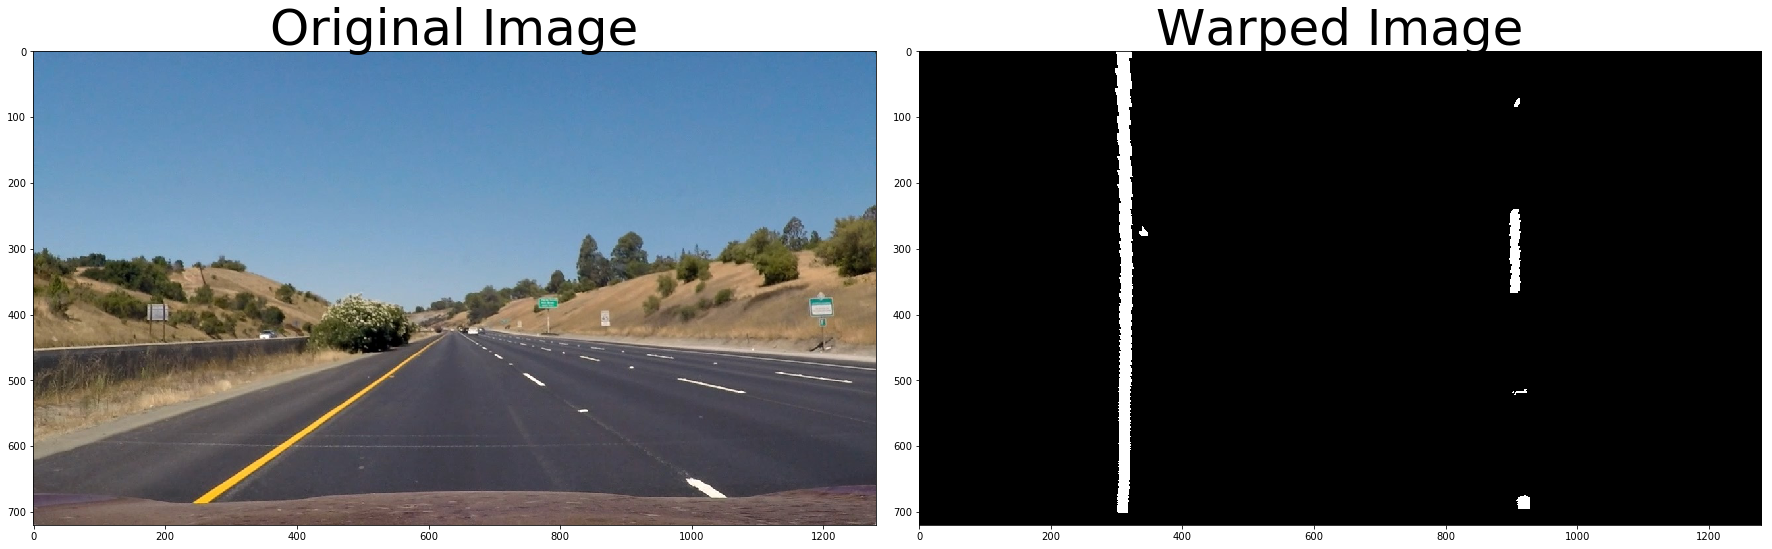

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detecting lines with sliding window

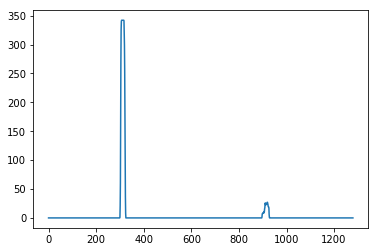

In [58]:
histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)
midpoint = np.int(histogram.shape[0]/2)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

plt.plot(histogram)

## Sliding windows search

(720, 0)

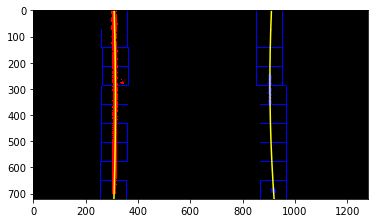

In [59]:
out_img = np.dstack((warped, warped, warped))*255

non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

(720, 0)

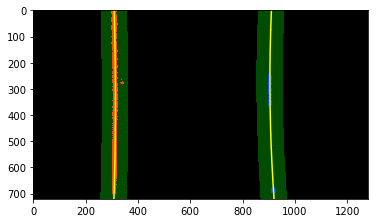

In [60]:
margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

In [61]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 2955.85 m
Center offset: 0.14 m


## Inverse transform

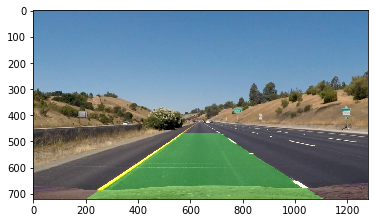

In [62]:
out_img = np.dstack((warped, warped, warped))*255
y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)

plt.imshow(result)

## Final pipeline

In [1]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = get_threshold(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

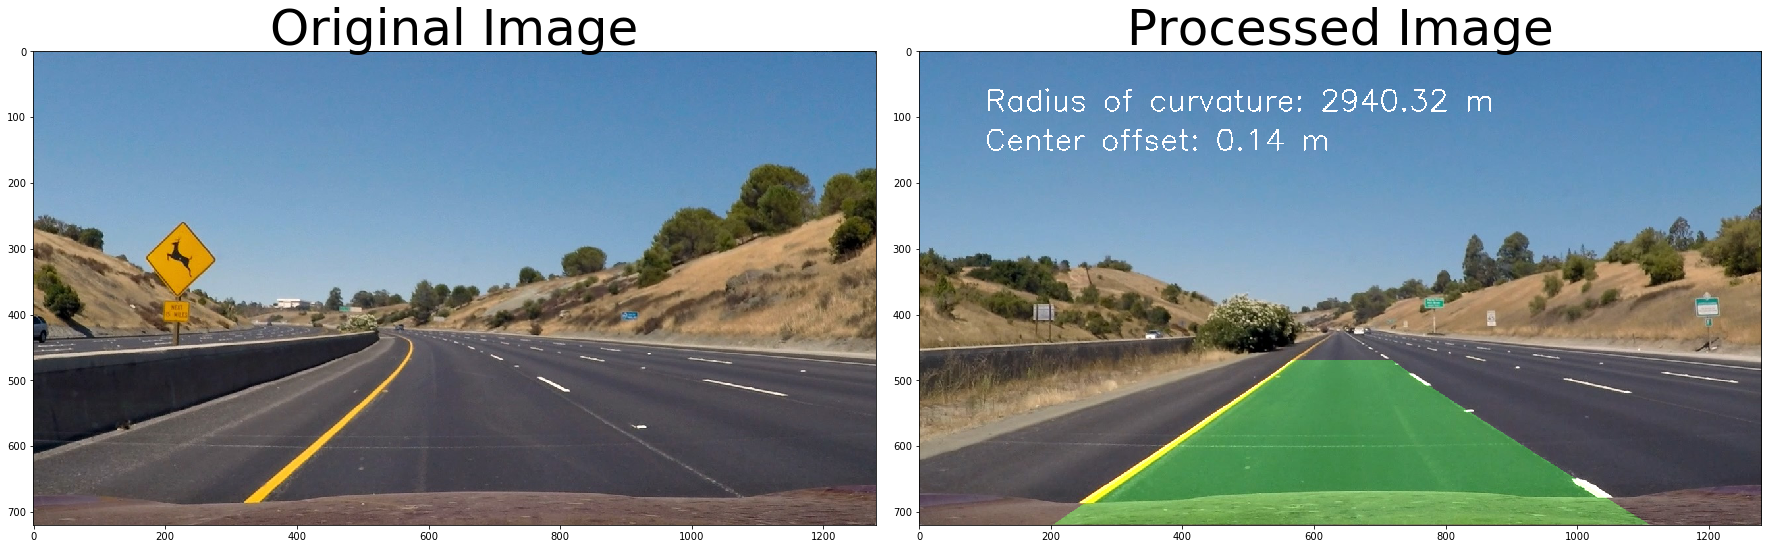

In [72]:
img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(image)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Output visual display

In [73]:
from moviepy.editor import VideoFileClip

polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [10:56<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 15s, sys: 32.9 s, total: 13min 48s
Wall time: 10min 59s


## Challenge video

In [74]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [04:43<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 22s, sys: 14.3 s, total: 5min 36s
Wall time: 4min 46s
